In [626]:
import numpy as np
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal, interpolate
from numpy.fft import fft
from itertools import combinations
import math

def cross_corr(y1, y2):  
    if len(y1) != len(y2):
        raise ValueError('The lengths of the inputs should be the same.')

    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    corr = signal.correlate(y1, y2, mode='same')
    unbiased_sample_size = signal.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    shift = len(y1) // 2

    max_corr = np.max(corr)
    argmax_corr = np.argmax(corr)
    return max_corr, argmax_corr - shift

def LPF(order, fc, fs):
    nyq = 0.5*fs
    fc_norm=fc/nyq
    b,a = signal.butter(order, fc_norm, btype='low')
    return b,a

def BPF(order, fl, fh, fs):
    nyq = 0.5*fs
    low=fl/nyq
    high=fh/nyq
    b,a = signal.butter(order, [low, high], btype='band')
    return b,a

In [627]:
# data import
Settings = 2
User = 1
DevLoc_path = 'DevLoc'+str(Settings)+'.csv'   # location of devices where device contains 6 mics
DevLoc = np.genfromtxt(DevLoc_path, delimiter=',')
Mic = np.zeros((24000,6,8))
for i in range(8):
    Mic_path = 'user'+str(User)+'_setting'+str(Settings)+'/'+str(i+1)+'.csv'      # measured data from mic arrays
    Mic[:,:,i] = np.genfromtxt(Mic_path, delimiter=',')
    
    
print(Mic[:,:,5])
print(DevLoc.shape)


[[0.0055542 0.0055542 0.0057526 0.0060577 0.0064697 0.0056915]
 [0.0052795 0.0053253 0.0057831 0.0060272 0.0064545 0.005249 ]
 [0.0052643 0.0048676 0.0054779 0.006424  0.0062866 0.0050812]
 ...
 [0.0072632 0.0069122 0.0071869 0.0069275 0.008255  0.0077972]
 [0.0067902 0.0064392 0.006897  0.0069885 0.0080109 0.0068054]
 [0.0070496 0.0062256 0.0064392 0.0071716 0.0071259 0.0067139]]
(8, 2)


In [628]:
# Define parameters
vp = 330   # Propagation speed  [m/s]

Ns = len(Mic[:,0,0])    # Number of samples per single mic
fs = 16000  # [Hz]     # Sampled freq
ts = 1/fs  # Sampled time
t = np.arange(0,ts*Ns,ts)
freq = np.arange(0,fs,fs/Ns)
n = np.arange(0,Ns,1)
radius = 0.5*0.09218   # distance in meter from center of a single device.


r = np.zeros((6,2))   # Relative location of each microphone from device center
for i in range(6):
    r[i,0] = radius*cos((1-i)*pi/3)
    r[i,1] = radius*sin((1-i)*pi/3)



In [629]:
# Bandpass Filtering around 100Hz~2kHz

b,a = BPF(4,100,1500,fs)
w,h = signal.freqs(b,a)
for k in range(8):    
    for i in range(6):
        Mic[:,i,k] = signal.filtfilt(b,a,Mic[:,i,k])


# Let us interpolate the signal to oversample by Shrink_factor(SF) times.

SF = 4
n_new = np.arange(0,(Ns-1)+1/SF,1/SF)
Mic_new = np.zeros((len(n_new),6,8))

for k in range(8):
    for i in range(6):
        func = interpolate.interp1d(n,Mic[:,i,k])
        Mic_new[:,i,k]=func(n_new)
    

ts_new = ts/SF
Ns_new = len(Mic_new[:,0,0])
t_new = np.arange(0,ts_new*Ns_new,ts_new)




# Calculate relative time lag referenced to each microphone elements

# From relation: r_ij dot alpha = t_ij * vp. 
#comb = combinations([0,1,2,3,4,5],2)
r_ij = np.zeros((15,2))
dtau = np.zeros(15)
Vxy = np.zeros((2,8))
#for (i,j) in list(comb):
#    print(i,j)
lag_temp = np.zeros((15,8))

for k in range(8):
    comb = combinations([0,1,2,3,4,5],2)
    print(k)
    q=0
    for (i,j) in list(comb):
        #print(i,j)
        r_ij[q] = r[i,:] - r[j,:]
        corr, lag = cross_corr(Mic_new[:,j,k], Mic_new[:,i,k])
        dtau[q] = lag*ts_new
        lag_temp[q,k]=lag

        q=q+1
    Vxy[:,k] = np.linalg.inv(r_ij.T@r_ij)@r_ij.T@dtau.T




# [dtau]vp = [r_ref][X] where [X] is the direction vector toward the user U(x,y)
# Finding Least sqaure solution

print(Vxy.T)



0
1
2
3
4
5
6
7
[[-6.78021263e-04  3.26213132e-04]
 [-4.14346327e-04 -9.78639396e-05]
 [ 4.89682023e-04 -2.60970506e-04]
 [-1.13003544e-03  2.60970506e-04]
 [ 1.70447012e-03 -1.06019268e-03]
 [ 4.04929365e-04  1.79417223e-04]
 [ 8.47526578e-04  3.58834445e-04]
 [-7.34523035e-04 -2.93591819e-04]]


0.007640995971652767
0.006226122454242147
0.006398576040500367
0.007670408703672447
0.013602539719509586
0.0049786835789079435
0.008447433767997848
0.005035595366657142
[0.52876342 0.4504314  0.43800128 0.53907037 1.         0.39674489
 0.37925781 0.33232863]


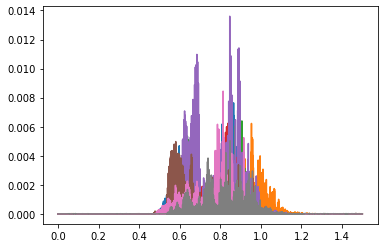

In [630]:
flag=np.ones(8)
for i in range(8):
    #if np.max(np.square(Mic_new[:,0,i])) < 0.25 * np.max(np.square(Mic_new[:,0,:])):
    #    flag[i]=0
    #    continue
    flag[i]=np.average(np.square(Mic_new[:,0,i]))
    
    plt.plot(t_new, np.square(Mic_new[:,0,i]))
    print(max(np.square(Mic_new[:,0,i])))
flag = flag/np.max(flag)
print(flag)

In [631]:
# Triangulation.  Assuming ax+by=c lines meet in one line is to solve least square problem.   [A] [Xu] = [C] 
A = Vxy.T[:,[1,0]]@[[1,0],[0,-1]]

# [C] = [beta,alpha] dot [DevLoc_x, DevLocy]
c = np.zeros(8)
for i in range(8):
    c[i] = A[i,:]@DevLoc[i,:]
print(c)


#weights = [1,1,1,1,1,1,1,1]

weights = flag
W = np.diag(flag)
print(W)

Uxy = np.linalg.inv(A.T@W@A)@A.T@W@c


[ 0.00101703  0.0016199   0.          0.00130485 -0.00520719 -0.00121479
  0.00089709  0.00029495]
[[0.52876342 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.4504314  0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.43800128 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.53907037 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.39674489
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.37925781 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.33232863]]


(600, 8)
[[-6.78021263e-04  3.26213132e-04]
 [-4.14346327e-04 -9.78639396e-05]
 [ 4.89682023e-04 -2.60970506e-04]
 [-1.13003544e-03  2.60970506e-04]
 [ 1.70447012e-03 -1.06019268e-03]
 [ 4.04929365e-04  1.79417223e-04]
 [ 8.47526578e-04  3.58834445e-04]
 [-7.34523035e-04 -2.93591819e-04]]
User Location:  [2.73850967 1.12430081]
Error[m] =  1.2675995190644336


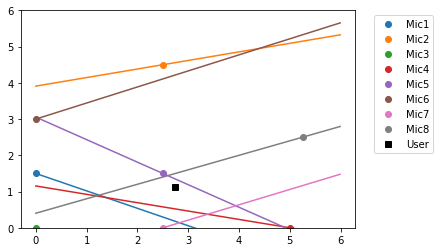

In [632]:
#Plotting the graph 
x = np.arange(0,6,0.01)
y = np.zeros((len(x),8))

for i in range(8):
    if flag[i] == 0:
        y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
        plt.plot(x,y[:,i],':')
        continue
    if Vxy.T[i,1] == 0:
        plt.plot(1,-100)
        continue
    y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
    plt.plot(x,y[:,i])

plt.gca().set_prop_cycle(None)
for i in range(8):
    plt.plot(DevLoc[i,0],DevLoc[i,1],'o', label='Mic'+str(i+1))

print(y.shape)

print(Vxy.T)
plt.plot(Uxy[0],Uxy[1],'s', label='User', color='black')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.ylim([0,6])

print("User Location: ", Uxy)
if Settings==1:
    Error = np.linalg.norm(Uxy-[3,1])
if Settings==2:
    Error = np.linalg.norm(Uxy-[4,1])
    
print('Error[m] = ',Error)



In [633]:
# Check the validity
Vxy_est = Uxy-DevLoc

print(flag)
for i in range(8):
    print(Vxy_est[i,:]@Vxy[:,i])
    if Vxy_est[i,:]@Vxy[:,i] < 0:
        flag[i]=0
print(flag)

[0.52876342 0.4504314  0.43800128 0.53907037 1.         0.39674489
 0.37925781 0.33232863]
-0.00197932579547055
0.00023153361576136388
0.0010475896056277626
0.002848973564533264
0.0008048461406851754
0.0007723702432154934
0.0006055811422427164
0.0022486415259874463
[0.         0.4504314  0.43800128 0.53907037 1.         0.39674489
 0.37925781 0.33232863]


User Location_new:  [2.76588695 1.16623213]
Error_new[m] =  1.245258262890892


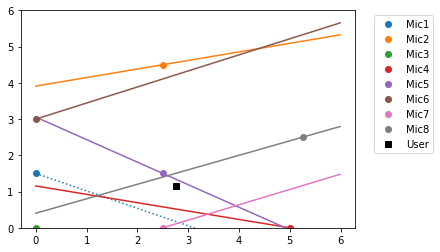

In [634]:
# Repeat once
for k in range(8):
    comb = combinations([0,1,2,3,4,5],2)
    q=0
    for (i,j) in list(comb):

        r_ij[q] = r[i,:] - r[j,:]
        corr, lag = cross_corr(Mic_new[:,j,k], Mic_new[:,i,k])
        dtau[q] = lag*ts_new
        lag_temp[q,k]=lag
        q=q+1
    Vxy[:,k] = np.linalg.inv(r_ij.T@r_ij)@r_ij.T@dtau.T

# Triangulation.  Assuming ax+by=c lines meet in one line is to solve least square problem.   [A] [Xu] = [C] 
A = Vxy.T[:,[1,0]]@[[1,0],[0,-1]]
c = np.zeros(8)
for i in range(8):
    c[i] = A[i,:]@DevLoc[i,:]    

W = np.diag(flag)

Uxy = np.linalg.inv(A.T@W@A)@A.T@W@c
Vxy_est = Uxy-DevLoc

for i in range(8):
    if flag[i] == 0:
        y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
        plt.plot(x,y[:,i],':')
        continue
    if Vxy.T[i,1] == 0:
        plt.plot(1,-100)
        continue
    y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
    plt.plot(x,y[:,i])

plt.gca().set_prop_cycle(None)
for i in range(8):
    plt.plot(DevLoc[i,0],DevLoc[i,1],'o', label='Mic'+str(i+1))

plt.plot(Uxy[0],Uxy[1],'s', label='User', color='black')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.ylim([0,6])

print("User Location_new: ", Uxy)
if Settings==1:
    Error = np.linalg.norm(Uxy-[3,1])
if Settings==2:
    Error = np.linalg.norm(Uxy-[4,1])
    
print('Error_new[m] = ',Error)